In [1]:
"""
Visual Sudoku problem in CPMpy
"""

from cpmpy import * 
import numpy as np 
from scipy.stats import poisson
import torch 
from torchvision import datasets, transforms

from cpmpy.solvers.ortools import CPM_ortools
from cpmpy.solvers.solver_interface import ExitStatus

import matplotlib.pyplot as plt

PRECISION = 1e-4

In [42]:
# Sudoku modeling 

def sudoku_model(grid):
    n = len(grid)
    b = np.sqrt(n).astype(int)

    # decision vars
    puzvar = IntVar(1,n, shape=grid.shape, name='cell')
    
    # alldiff constraint
    constraints = []
    constraints += [alldifferent(row) for row in puzvar]
    constraints += [alldifferent(col) for col in puzvar.T]
    for i in range(0,n,b):
        for j in range(0,n,b):
            constraints += [alldifferent(puzvar[i: i +b, j:j+b])]
    
    return puzvar, constraints 


def solve_vizsudoku_baseline(puzvar, constraints, logprobs, is_given):
    """
        Baseline: take most likely digit as deterministic input
    """
    cons = [*constraints]
    givens = np.argmax(logprobs, axis=2)
    cons += [puzvar[is_given] == givens[is_given]]
    model = Model(cons)
    if model.solve():
        return puzvar.value()
    else:
        return np.zeros_like(puzvar)


def solve_vizsudoku_hybrid1(puzvar, constraints, logprobs, is_given):
    """
        objective function: maximum log-likelihood of all digits
    """
    lprobs = np.array(-logprobs/PRECISION).astype(int)
    obj = sum(Element(lp, v) for lp,v in zip(lprobs[is_given], puzvar[is_given]))
    model = Model(constraints, minimize=obj)

    if model.solve():
            return puzvar.value()
    else:
        return np.zeros_like(puzvar)

def is_unique(solution, is_given):
    """
        Check whether this solution is unique for the givens
    """
    puzvar, constraints = sudoku_model(solution)
    constraints += [puzvar[is_given] == solution[is_given]]
    # forbid current solution 
    constraints += [any((puzvar != solution).flatten())] #FIXME auto-flatten 2d dvar arrays?
    model= CPM_ortools(Model(constraints))
    return not model.solve(stop_after_first_solution=True)


def solve_vizsudoku_hybrid2(puzvar, constraints, logprobs, is_given, max_iter=10):
    """
        Higher order knowledge exploitation: the solution should be unique when solving from givens
    """
    cons = [*constraints]
    solution = solve_vizsudoku_hybrid1(puzvar, cons, logprobs, is_given)
    i = 0
    while not is_unique(solution, is_given):
        if i == max_iter:
            break 
        # forbid current solution
        cons += [any(puzvar[is_given] != solution[is_given])]
        solution = solve_vizsudoku_hybrid1(puzvar, cons, logprobs, is_given)
        i += 1
    print(i)
    return solution


In [3]:
# Build Visual Sudoku problem from MNIST data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the MNIST data
testset = datasets.MNIST('.', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
digit_indices = {k:torch.LongTensor(*np.where(testset.targets == k)) for k in range(1,10)}

# sample a dataset index for each non-zero number
def sample_visual_sudoku(sudoku_p):
    nonzero = sudoku_p > 0
    vizsudoku = torch.zeros((9,9,1,28,28), dtype=torch.float32)
    for val in np.unique(sudoku_p[nonzero]):
        val_idx = np.where(sudoku_p == val)
        idx = torch.LongTensor(np.random.choice(digit_indices[val], len(sudoku_p[val_idx])))
        vizsudoku[val_idx] = torch.stack([testset[i][0] for i in idx])
    return vizsudoku

In [10]:
## Helper functions for visualisation

def show_grid_img(images):
    dim = 9
    #figure = plt.figure()
    num_of_images = dim*dim
    for index in range(num_of_images):
        plt.subplot(dim, dim, index+1)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


imgs_supply = {k:testset.data[digit_indices[k]] for k in range(1,10)}

##helper function to plot and compare solution found with hybrid approach
def plot_vs(visualsudoku, output, is_given, ml_digits, solution):
    n = 9
    fig, axes = plt.subplots(n, n, figsize=(1.5*n,2*n))

    for i in range(n*n):
        ax = axes[i//n, i%n]
        # sample image w.r.t. solver output
        img = torch.zeros(28,28).float()
        c = 'gray'
        if not is_given.reshape(-1)[i]:
            # cell filled by the solver in gray
            img = imgs_supply[output.reshape(-1)[i]][1]
            #TODO use 'computer generated' digit images instead
        else:
            img = visualsudoku.view(-1, 28,28)[i].squeeze()
            # wrong given -> red
            # given fixed by cp -> green
            c = 'gray' if output.reshape(-1)[i] == ml_digits.reshape(-1)[i] else 'summer'

        c = 'autumn' if is_given.reshape(-1)[i] and output.reshape(-1)[i] != solution.reshape(-1)[i] else c

        if c == 'summer':
            ax.set_title('CNN label: {}\nsolver label: {}'.format(ml_digits.reshape(-1)[i], output.reshape(-1)[i]))
        elif c == 'autumn':
            ax.set_title('solver label: {}\nTrue label: {}'.format(output.reshape(-1)[i], solution.reshape(-1)[i]))
            
        ax.imshow(img, cmap=c)
        ax.set_axis_off()


def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze(), cmap='gray_r');
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

@torch.no_grad()
def show_one_prediction(model, data, i=0):
    img, label = data[i]
    logps = model(img.unsqueeze(0))
    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    view_classify(img, ps)
    print("Predicted Digit =", probab.index(max(probab)), "\tActual =",label)

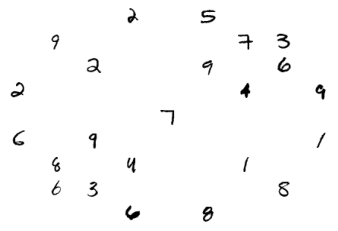

In [8]:
# Let's build a Visual Sudoku instance

puzzle = np.array(
    #TODO find difficult puzzle in SATNet dataset
        [[0,0,0, 2,0,5, 0,0,0],
        [0,9,0, 0,0,0, 7,3,0],
        [0,0,2, 0,0,9, 0,6,0],
        [2,0,0, 0,0,0, 4,0,9],
        [0,0,0, 0,7,0, 0,0,0],
        [6,0,9, 0,0,0, 0,0,1],
        [0,8,0, 4,0,0, 1,0,0],
        [0,6,3, 0,0,0, 0,8,0],
        [0,0,0, 6,0,8, 0,0,0]]
    )
vs = sample_visual_sudoku(puzzle)

show_grid_img(vs.reshape(-1, 28, 28))


Predicted Digit = 2 	Actual = 2
Predicted Digit = 6 	Actual = 6
Predicted Digit = 9 	Actual = 9


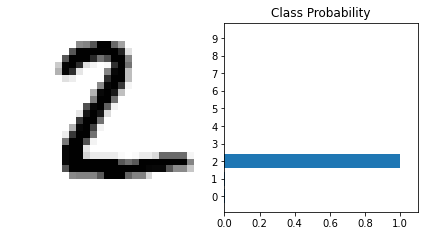

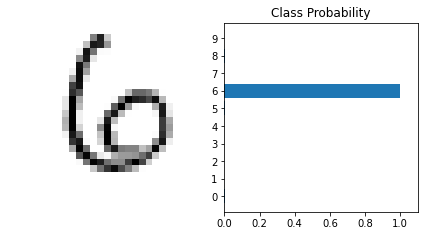

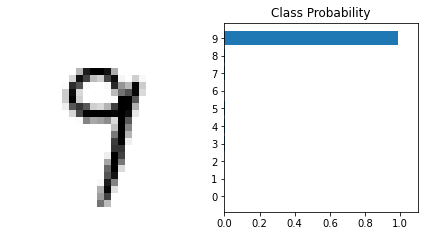

In [34]:
## Convolutional Neural Network for digit classification

from torch import nn 
import torch.nn.functional as F
class LeNet(nn.Module):
    def __init__(self, calibrated=False):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*16) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

def load_clf(clf_classname, path):
    net = clf_classname()
    state_dict = torch.load(path, map_location=lambda storage, loc: storage)
    net.load_state_dict(state_dict)
    return net

@torch.no_grad()
def predict_proba_sudoku(model, vizsudoku):
    # reshape from 9x9x1x28x28 to 81x1x28x28
    pred = model(vizsudoku.flatten(0,1))
    # our NN return 81 probabilistic vector: an 81x10 matrix
    return pred.reshape(9,9,10).detach() # reshape as 9x9x10 tensor for easier visualisation

# load pre-trained classifier
cnn = load_clf(LeNet,'mnist_lenet_e10.pt' ) #TODO host elsewhere and load from url
for i in [1, 100, 2456]:
    # TODO use less confident networks? or use log scale
    show_one_prediction(cnn, testset, i)

In [25]:
# (log)probabilities for each cell
logprobs = predict_proba_sudoku(cnn, vs)
print("(log) probability tensor ", logprobs.shape)
is_given = puzzle > 0
# maximum likelihood class 
ml_digits = np.argmax(logprobs, axis=-1)
dvar, cons = sudoku_model(puzzle) 

# True Solution
cons += [dvar[is_given] == puzzle[is_given]]
model = Model(cons) 
model.solve()
solution = dvar.value()
solution

(log) probability tensor  torch.Size([9, 9, 10])


array([[3, 7, 8, 2, 6, 5, 9, 1, 4],
       [5, 9, 6, 8, 1, 4, 7, 3, 2],
       [1, 4, 2, 7, 3, 9, 5, 6, 8],
       [2, 1, 7, 3, 8, 6, 4, 5, 9],
       [8, 5, 4, 9, 7, 1, 6, 2, 3],
       [6, 3, 9, 5, 4, 2, 8, 7, 1],
       [7, 8, 5, 4, 2, 3, 1, 9, 6],
       [4, 6, 3, 1, 9, 7, 2, 8, 5],
       [9, 2, 1, 6, 5, 8, 3, 4, 7]])

In [ ]:
dvar, cons = sudoku_model(puzzle) 
## baseline 
# sol1 = solve_vizsudoku_baseline(dvar, cons,logprobs, is_given)
# plot_vs(vs, sol1, is_given, ml_digits, solution)


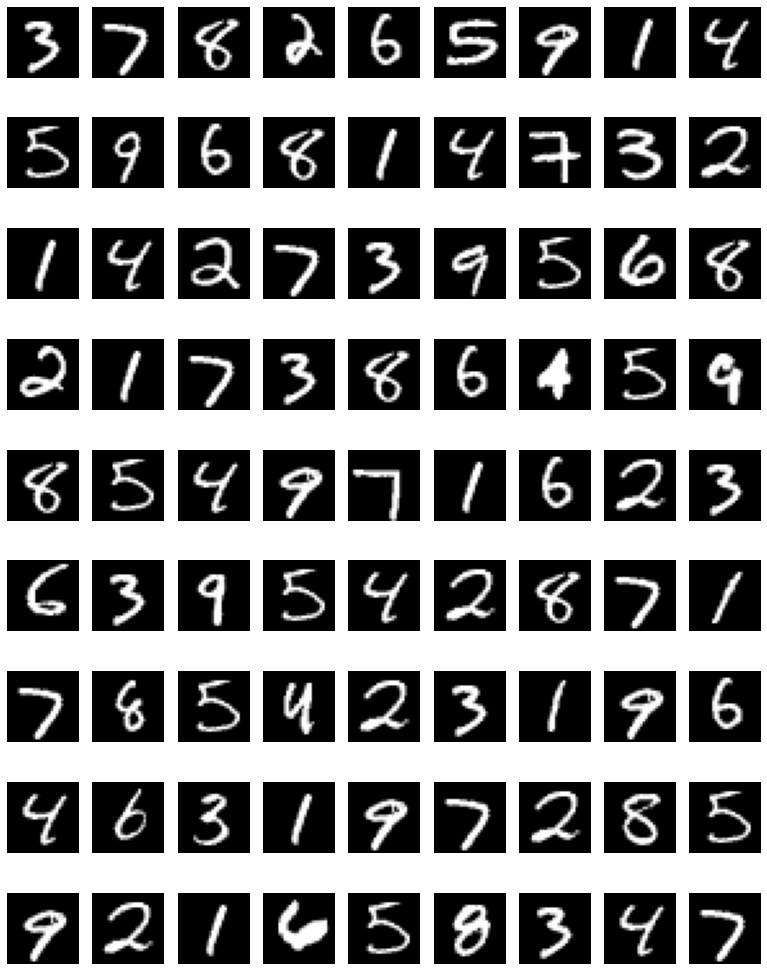

In [38]:
## Hybrid 1
dvar, cons = sudoku_model(puzzle) 
sol2 = solve_vizsudoku_hybrid1(dvar, cons,logprobs, is_given)
plot_vs(vs, sol2, is_given, ml_digits, solution)


0


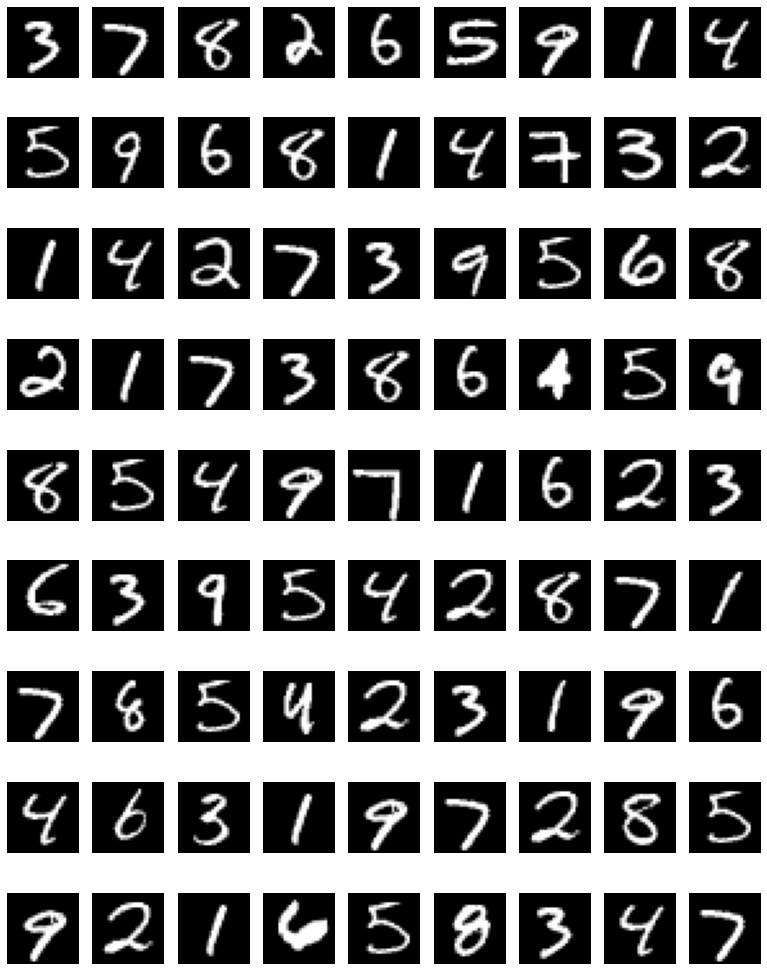

In [43]:
dvar, cons = sudoku_model(puzzle) 
sol3 = solve_vizsudoku_hybrid2(dvar, cons,logprobs, is_given)
plot_vs(vs, sol3, is_given, ml_digits, solution)